# Maskinlæring innlevering 2
## forrutse om en person i USA tjener mer eller mindre enn 50 tusen dollar

Ifølge oppgaven skal vi forrutse om en person tjener mer eller mindre enn 50 tusen dollar i året i USA. 

Vi følger metodene som vi brukte i forrige innlevering:

1. Hent data og les om hva dataene omhandler
2. Utforsk datene
3. Forbered dataene for trening og maskinlæringsalgoritmer
4. Utforsk hvilke modeller som burde fungere bra på dette datasettet
5. Fiks opp i modellene og kombiner de beste sammen
6. Presenter løsningen
7. Deploy/rull ut løsningen og forbered løsningen på viderehåndtering

### 1. Hent data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import seaborn as sns

# Setter random seed for å gjøre resultatene reproduserbare.
np.random.seed(38)

# For at grafer skal vises ordentlig i notebooken:
%matplotlib inline

In [2]:
def lastData():
    csvPath = os.path.join("data", "adult.csv")
    return pd.read_csv(csvPath)


In [3]:
data = lastData()

In [4]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


En kjapp titt på datasettet viser at vi har mange ikke numeriske datafelt. Flere av datafeltene inneholder ?. 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Ser at der er ingen null verdier i datasettet, men det er flere felter som er fyllt ut med ?. Disse feltene er felter som muligens burde vært null. La os sjekke om det er noen datafelter som har en sterk korelasjon til inntekten slik at vi kan lage et representativt testsett.

In [6]:
uaData = data.copy()
nonNumCol=['workclass', 'education', 'marital.status',
           'occupation', 'relationship', 'race', 'sex',
           'native.country', 'income']

In [7]:
def changeToCat(data, nonNumCol):    
    for column in nonNumCol:
        data[column] = data[column].astype('category').cat.codes

In [8]:
changeToCat(data, nonNumCol)
kor=data.corr()
kor['income'].sort_values(ascending = False)

income            1.000000
education.num     0.335154
age               0.234037
hours.per.week    0.229689
capital.gain      0.223329
sex               0.215980
capital.loss      0.150526
education         0.079317
occupation        0.075468
race              0.071846
workclass         0.051604
native.country    0.015840
fnlwgt           -0.009463
marital.status   -0.199307
relationship     -0.250918
Name: income, dtype: float64

Her er ingen datafelt som utmerker seg som spesielt viktig. Vi kan derfor ta ut et tilfelding test set. fnlwgt utmerker seg som spesielt uviktig, vi kan dermed fjerne denne.

### 2. Utforsk dataene

In [9]:
from sklearn.model_selection import train_test_split

targets = uaData['income']
splitData = uaData.drop(['income'], axis=1)

dataTrain, dataTest, trainTarget, testTarget = train_test_split(splitData, targets, test_size = 0.3)

data=dataTrain.copy()
data['income'] = trainTarget

Under kan vi se mye info fra hver attributt. for eksempel kan vi se at det er dobbelt så mange menn enn kvinner i datasettet. Mange av disse mennene er hvite og gifte. De fleste jobber i privat sektor og de aller fleste har en videregående utdanning etterfulgt av ungdomsskolen. en kan også se at det er flest som jobber 40 timer i uken og detter er en representativt for en vanlig 8 timers arbeidsag. 

In [10]:
for column in nonNumCol: 
    print(data[column].value_counts())
    print("-------------------------")

Private             15896
Self-emp-not-inc     1767
Local-gov            1474
?                    1265
State-gov             917
Self-emp-inc          780
Federal-gov           680
Without-pay             8
Never-worked            5
Name: workclass, dtype: int64
-------------------------
HS-grad         7285
Some-college    5092
Bachelors       3702
Masters         1267
Assoc-voc        972
11th             840
Assoc-acdm       764
10th             663
7th-8th          448
Prof-school      404
9th              375
12th             301
Doctorate        290
5th-6th          232
1st-4th          124
Preschool         33
Name: education, dtype: int64
-------------------------
Married-civ-spouse       10492
Never-married             7451
Divorced                  3129
Separated                  711
Widowed                    706
Married-spouse-absent      286
Married-AF-spouse           17
Name: marital.status, dtype: int64
-------------------------
Prof-specialty       2933
Craft-repair  

Under kan vi se noen kalkulerte verdier ut ifra tall-attributtene i datasettet. 

Det er 32561 mennesker i datasettet
Gjennomsnittsalderen er 38 år
Gjennomsnitts utdanningen er på 10, men husk at education.num er en annen attributt enn education. Vi ser at education.num bare er en numerisk representasjon av education. altså er Gjennomsnitts utdanningen 10 det samme som ungdomsskole utdanning.
Vi ser også at det er flere som tjener penger enn at de taper penger ut ifra verdiene capital.gain og capital.loss.
Gjennomsnittstimene per uke er som sagt tidligere 40 timer.

In [11]:
#Ikke helt sikker om dette er nødvendig. Alternativt kan ? erstattes med other eller de kan beholdes som en kategori.
def erstattNull(data):
    data[data == '?'] = np.nan
    columns = data.columns[data.isna().any()].tolist()
    for column in columns:
        data[column].fillna(data[column].mode()[0], inplace=True)

In [12]:
#erstattNull(data)
#data.head()

Vi har nå null verdier i workclass, occupation og native.country. Vi erstatter disse med medianen.

In [13]:
catData = data.copy()
changeToCat(catData, nonNumCol)
catData.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
30621,18,2,466325,1,7,4,1,3,4,1,0,0,12,39,0
1275,39,0,103986,11,9,4,0,1,4,1,0,1590,40,39,0
10671,30,6,176185,7,12,2,12,0,4,1,0,0,60,20,0
25007,26,6,68729,11,9,4,12,2,1,1,0,0,50,39,1
31901,26,4,746432,11,9,4,6,3,2,1,0,0,48,39,0


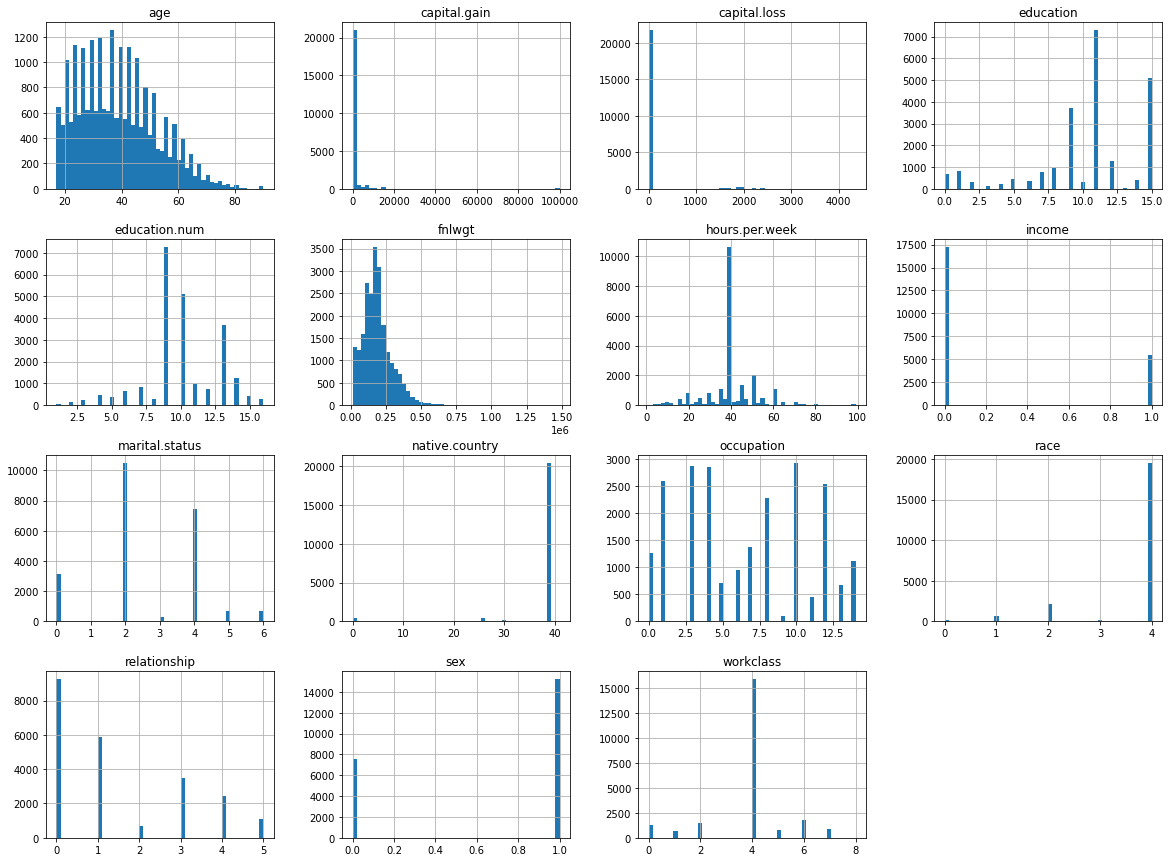

In [14]:
catData.hist(bins = 50, figsize = (20,15))
plt.show()

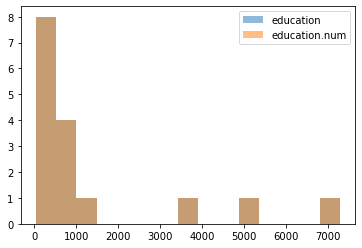

In [15]:
plt.hist(data['education'].value_counts(), bins=15, label='education', alpha=0.5)
plt.hist(data['education.num'].value_counts(), bins=15, label='education.num', alpha=0.5)
plt.legend(loc='best')
plt.show()

education.num og education er to variabler som sier det samme. Vi kan dermed dropp en av de.

In [16]:
data.drop('education', axis=1,inplace=True)

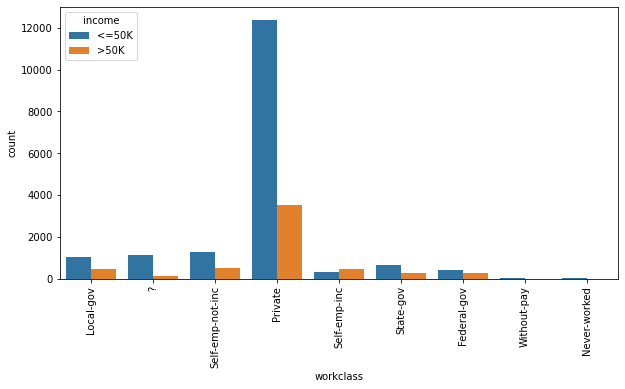

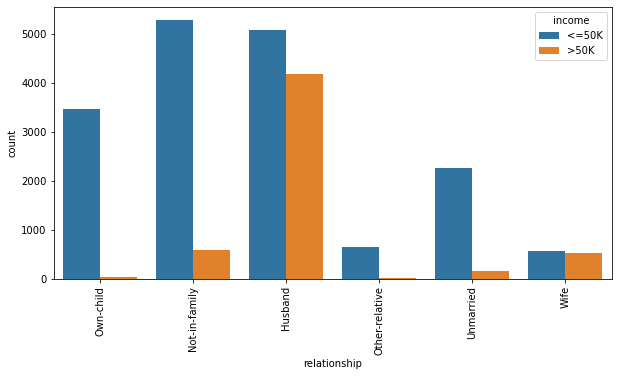

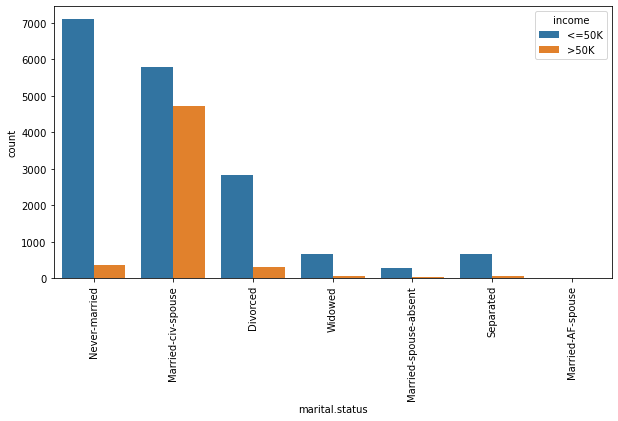

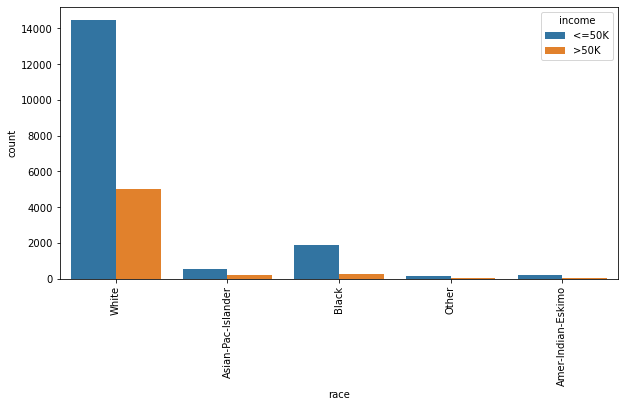

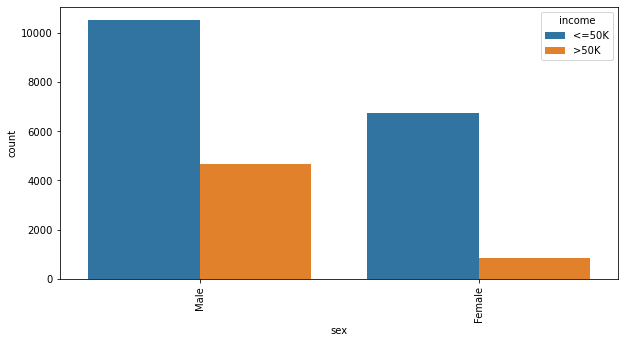

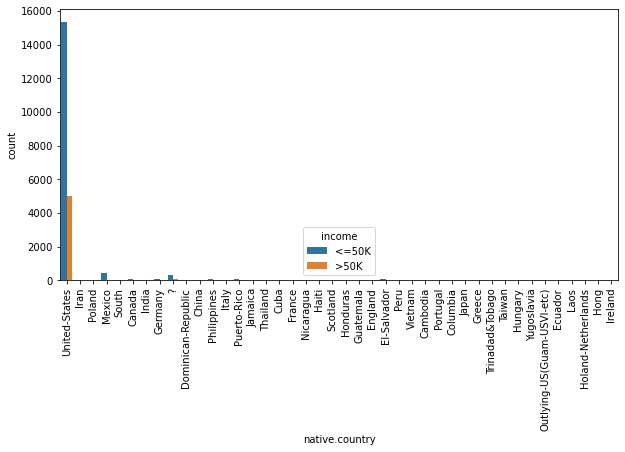

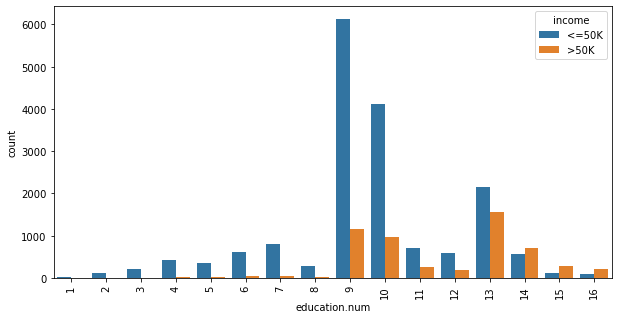

In [17]:
columns=['workclass', 'relationship', 'marital.status', 'race', 'sex', 'native.country', 'education.num']
for column in columns:
    plt.figure(figsize=(10,5))
    a = sns.countplot(data[column], hue=data['income'])
    a.set_xticklabels(a.get_xticklabels(), rotation=90)

Vi prøver å samle rase, sivilstatus og opprinnelsesland i mindtre grupper slik at det ikke er et dominant datafelt.

In [18]:
combData = data.copy()
combData['race'].replace(['Black', 'Asian-Pac-Islander','Amer-Indian-Eskimo'], 'Other', inplace=True)
combData['marital.status'].replace(['Divorced', 'Widowed', 'Separated', 'Married-spouse-absent'], 
                                   'No-longer-married', inplace=True)
combData['marital.status'].replace(['Married-AF-Spouse', 'Married-civ-spouse'], 'Married-present-spouse', inplace=True)
combData.loc[~combData['native.country'].isin(['United-States']), 'native.country'] = 'Not-US'
combData['capital.diff'] = combData['capital.gain']-combData['capital.loss']

In [19]:
noEdu = nonNumCol.copy()
noEdu.remove('education')

In [20]:
changeToCat(combData, noEdu)

combCor=combData.corr()
combCor['income'].sort_values(ascending = False)

income            1.000000
education.num     0.333550
age               0.232189
hours.per.week    0.228238
capital.gain      0.224745
sex               0.216284
capital.diff      0.216183
capital.loss      0.145166
race              0.086405
occupation        0.080453
workclass         0.050373
native.country    0.032687
fnlwgt           -0.010225
relationship     -0.249277
marital.status   -0.380502
Name: income, dtype: float64

In [21]:
numData=data.copy()
changeToCat(numData, noEdu)

kor=numData.corr()
kor['income'].sort_values(ascending = False)

income            1.000000
education.num     0.333550
age               0.232189
hours.per.week    0.228238
capital.gain      0.224745
sex               0.216284
capital.loss      0.145166
occupation        0.080453
race              0.074598
workclass         0.050373
native.country    0.011279
fnlwgt           -0.010225
marital.status   -0.197028
relationship     -0.249277
Name: income, dtype: float64

In [22]:
((combCor['income'])-(kor['income'])).sort_values(ascending = False)

native.country    0.021408
race              0.011806
workclass         0.000000
sex               0.000000
relationship      0.000000
occupation        0.000000
income            0.000000
hours.per.week    0.000000
fnlwgt            0.000000
education.num     0.000000
capital.loss      0.000000
capital.gain      0.000000
age               0.000000
marital.status   -0.183474
capital.diff           NaN
Name: income, dtype: float64

Innskrenkingen av rase, opphavsland og sivilstatus ser ut til å ha bedre sammen heng med inntekten. Differansen i kapital ser ikke ut til å være en bedre indikator enn tap og vinst.

## 3. Forbered dataene for trening og maskinlæringsalgoritmer

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

def scale(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return pd.DataFrame(scaler.transform(data))
    
def lbEnc(data, nonNumCol):
    for column in nonNumCol:
        le = preprocessing.LabelEncoder()
        data[column] = le.fit_transform(data[column])

def combiner(data):
    data['race'].replace(['Black', 'Asian-Pac-Islander','Amer-Indian-Eskimo'], 'Other', inplace=True)
    data['marital.status'].replace(['Divorced', 'Widowed', 'Separated', 'Married-spouse-absent'], 
                                   'No-longer-married', inplace=True)
    data['marital.status'].replace(['Married-AF-Spouse', 'Married-civ-spouse'], 'Married-present-spouse', inplace=True)
    data.loc[~data['native.country'].isin(['United-States']), 'native.country'] = 'Not-US'
    data['capital.diff'] = data['capital.gain']-data['capital.loss']

def remover(data):
    data.drop('education', axis=1,inplace=True)
        
def readyData(data, nonNumCol):
    remover(data)
    combiner(data)
    erstattNull(data)
    lbEnc(data, nonNumCol)
    return (scale(data))

In [24]:
d = dataTrain.copy()
pData = readyData(d, ['workclass', 'marital.status',
                      'occupation', 'relationship', 'race', 'sex',
                      'native.country'])
target=trainTarget

C:\Users\Gudsteinn\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
from sklearn.ensemble import RandomForestClassifier

forestReg = RandomForestClassifier()
forestReg.fit(pData, target)

RandomForestClassifier()

In [27]:
forestRegScores = cross_val_score(forestReg, pData, target,
                             scoring="accuracy")
sum(forestRegScores)/5

0.8603892834631429

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(pData, target)

KNeighborsClassifier()

In [29]:
knnScore = cross_val_score(knn, pData, target,
                         scoring='accuracy')
sum(knnScore)/5

0.8357755240852203

In [30]:
from sklearn import svm

svc = svm.SVC()
svc.fit(pData, target)

SVC()

In [31]:
svcScore = cross_val_score(svc, pData, target,
                         scoring='accuracy')
sum(svcScore)/5

0.8495082801562006

In [32]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=800)
clf.fit(pData, target)

MLPClassifier(max_iter=800)

In [33]:
clfScore = cross_val_score(clf, pData, target,
                           scoring="accuracy")
sum(clfScore)/5

0.849201195269164

# Juster modellen

Den beste modellen vår er en random forrest classifier.
For å forbedre denne prøver vi å kjøre den gjennom en grid search algoritme og en random search algoritme.

In [34]:
from sklearn.model_selection import GridSearchCV

gridParameters = [
                  {'n_estimators': [3, 10, 30, 60, 90, 120, 150], 'max_features': [2, 4, 3, 5, 7, 9]},
                  {'bootstrap': [False], 'n_estimators': [3, 10, 30, 60], 'max_features': [2, 3, 4, 6]}
                  ]
gridSearch = GridSearchCV(RandomForestClassifier(), gridParameters, cv = 5, scoring="accuracy")
gridSearch.fit(pData, target)
print(gridSearch.best_params_)
print(gridSearch.best_score_)

{'max_features': 3, 'n_estimators': 90}
0.8618371041046256


In [35]:
from sklearn.model_selection import RandomizedSearchCV

rSParam = [{'n_estimators': [3, 10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300]}]
randomSearch = RandomizedSearchCV(RandomForestClassifier(),rSParam, n_iter = 10, scoring="accuracy")
randomSearch.fit(pData, target)
print(randomSearch.best_params_)
print(randomSearch.best_score_)

{'n_estimators': 210}
0.8619688274094581


Dette er den beste modellen vi har fått.

In [36]:
besteModel=randomSearch.best_estimator_

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
dt = dataTest.copy()
prosTest = readyData(dt, ['workclass', 'marital.status',
                      'occupation', 'relationship', 'race', 'sex',
                      'native.country'])

C:\Users\Gudsteinn\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [39]:
pred = besteModel.predict(prosTest)

## Sjekke modellen mot testsettet.

In [40]:
accuracy_score(testTarget, pred)

0.8495240045040434

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
confusion_matrix(testTarget, pred)

array([[6891,  553],
       [ 917, 1408]], dtype=int64)

In [43]:
from joblib import dump

In [44]:
dump(besteModel, "ACI_model.joblib", compress=3)

['ACI_model.joblib']

Vi må finne ut hvordan vi laster opp data transformeringen.